# NER Workshop Exercise 2: Training a Custom NER Algorithm

**In this exercise, we will train our own RNN-based Named Entity Recognition algorithm, using the CoNLL-2003 tagged dataset.**

## Part 1: Loading CoNLL-2003 data

<b>The [CoNLL-2003](https://www.clips.uantwerpen.be/conll2003/ner/) shared task was a joint effort by academics to provide approaches to named entity recognition, using a tagged dataset of named entities in English and German. We will be using the tagged English data from CoNLL-2003, found in the accompanying file *conll2003.zip*.

After uploading this file to the current directory, access the data as follows:</b>

In [1]:
import nltk
from nltk import FreqDist
from nltk import word_tokenize
from itertools import chain
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, TimeDistributed, Bidirectional
import pandas as pd
from keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, concatenate

Using TensorFlow backend.


In [2]:
# ! unzip conll2003.zip

In [3]:

def read_conll(filename):
    df = pd.read_csv(filename,
                     sep = ' ', header = None, keep_default_na = False,
                     names = ['TOKEN', 'POS', 'CHUNK', 'NE'],
                     quoting = 3, skip_blank_lines = False)
    df['SENTENCE'] = (df.TOKEN == '').cumsum()
    return df[df.TOKEN != '']


train_df = read_conll('conll2003/train.txt')
valid_df = read_conll('conll2003/valid.txt')
test_df = read_conll('conll2003/test.txt')

**Note that the CoNLL-2003 data contains part-of-speech (POS) and chunk tags, but we will only be using the token text and named entity (NE) tags that are provided.**

### Questions:
####  1. What percentages of the CoNLL-2003 data are training, validation, and testing data? (calculate directly)

In [4]:
common = len(train_df)+len(valid_df)+len(test_df)
print(f'percentages of the CoNLL-2003 data are:\n \
      training   {len(train_df)/common*100}%,\n \
      validation {len(valid_df)/common*100}%,\n \
      testing    {len(test_df)/common*100}%')

percentages of the CoNLL-2003 data are:
       training   67.55600027740076%,
       validation 17.033066830465206%,
       testing    15.410932892134038%



 #### 2. What do the tags in column 'NE' mean?

In [5]:
train_df.head()

,TOKEN,POS,CHUNK,NE,SENTENCE
0,-DOCSTART-,-X-,-X-,O,0
2,EU,NNP,B-NP,B-ORG,1
3,rejects,VBZ,B-VP,O,1
4,German,JJ,B-NP,B-MISC,1
5,call,NN,I-NP,O,1


In [6]:
train_df.NE.unique()

array(['O', 'B-ORG', 'B-MISC', 'B-PER', 'I-PER', 'B-LOC', 'I-ORG',
       'I-MISC', 'I-LOC'], dtype=object)

I-TYPE  means that the word is inside a phrase <br>B-TYPE means that the word starts a new phrase.

## Part 2: Feature calculation

**In order to learn named entity recognition using RNNs, we must transform our input and output into numeric vectors by calculating relevant features. For our basic NER algorithm, we will simply use word indices as input and one-hot embeddings of NER tags as output.**

### Questions:

#### 3. Save a list of the 5000 most common word tokens (values from column 'TOKEN') in our training data as a list 'vocab', and save a list of all unique entity tags (values from column 'NE') as a list 'ne_tags'. 


In [7]:
vocab = list(train_df.TOKEN.value_counts(ascending=False)[:5000].index)
ne_tags = list(train_df.NE.unique())
ne_tags

['O', 'B-ORG', 'B-MISC', 'B-PER', 'I-PER', 'B-LOC', 'I-ORG', 'I-MISC', 'I-LOC']

#### 4. Create a function token2index(token) that takes in the value of a word token and returns a unique integer. It should return 1 for any token which is not found in 'vocab' (i.e. which is out-of-vocabulary) and a number >= 2 for every token found in 'vocab'.


In [8]:
def token2index(token):
    if token not in (vocab):
        return 1
    else:
        return vocab.index(token)+2
    
#function check
token2index('.'),token2index('token')

(2, 1)

#### 5. Create a function ne_tag2index(ne_tag) which returns a unique integer >= 1 for every entity tag.


In [9]:
def ne_tag2index(ne_tag):
    return ne_tags.index(ne_tag)+1

#function check
ne_tag2index('O'), ne_tag2index('B-ORG') 

(1, 2)

#### 6. Add new columns 'token_index' and 'ne_index' to the CoNLL data DataFrames containing the values of token2index() and ne_tag2index() for each token and entity tag.


In [10]:
train_df['token_index'] = train_df['TOKEN'].apply(token2index)
valid_df['token_index'] = valid_df['TOKEN'].apply(token2index)
test_df['token_index'] = test_df['TOKEN'].apply(token2index)

train_df['ne_index'] = train_df['NE'].apply(ne_tag2index)
valid_df['ne_index'] = valid_df['NE'].apply(ne_tag2index)
test_df['ne_index'] = test_df['NE'].apply(ne_tag2index)
test_df

,TOKEN,POS,CHUNK,NE,SENTENCE,token_index,ne_index
0,-DOCSTART-,-X-,-X-,O,0,22,1
2,SOCCER,NN,B-NP,O,1,126,1
3,-,:,O,O,1,18,1
4,JAPAN,NNP,B-NP,B-LOC,1,1,6
5,GET,VB,B-VP,O,1,1,1
...,...,...,...,...,...,...,...
50344,younger,JJR,I-NP,O,3683,1,1
50345,brother,NN,I-NP,O,3683,1,1
50346,",",",",O,O,3683,3,1
50347,Bobby,NNP,B-NP,B-PER,3683,4343,4


#### 7. Generate training data feature matrix X_train of size (14987, 50) as follows:
  * <b>Use train_df.groupby('SENTENCE').token_index.apply(list) to get a list of lists of token indices, one list for each sentence.
  * Use pad_sequences() from keras.preprocessing.sequence to pad every list of token indices with the value '0' at the beginning so they are all of length 50.</b>


In [11]:
maxlen=50


In [12]:
X_group = train_df.groupby('SENTENCE').token_index.apply(list)
X_train = pad_sequences(X_group, maxlen=maxlen, padding='pre', value=0)
X_train.shape

(14987, 50)

#### 8. Generate output data feature matrix Y_train of size (14987, 50, 10) by applying the same method to the entity token indices (column 'ne_index'), and then one-hot encoding using to_categorical() from keras.utils.


In [13]:
Y_group = train_df.groupby('SENTENCE').ne_index.apply(list)
Y_pad = pad_sequences(Y_group,maxlen=maxlen, padding='pre', value=0).tolist()
Y_train = to_categorical(Y_pad, num_classes=10)
Y_train.shape

(14987, 50, 10)

#### 9. Apply 7-8 on the validation and testing data as well to generate matrices X_valid, Y_valid, X_test, Y_test.

X_valid

In [14]:
X_group_valid = valid_df.groupby('SENTENCE').token_index.apply(list)
X_valid = pad_sequences(X_group_valid, maxlen=maxlen, padding='pre', value=0)
X_valid.shape

(3466, 50)

Y_valid

In [15]:
Y_group_valid = valid_df.groupby('SENTENCE').ne_index.apply(list)
Y_pad_valid = pad_sequences(Y_group_valid,maxlen=maxlen, padding='pre', value=0).tolist()
Y_valid = to_categorical(Y_pad_valid, num_classes=Y_train.shape[2])
Y_valid.shape

(3466, 50, 10)

X_test

In [16]:
X_group_test = test_df.groupby('SENTENCE').token_index.apply(list)
X_test = pad_sequences(X_group_test, maxlen=maxlen, padding='pre', value=0)
X_test.shape

(3684, 50)

Y_test

In [17]:
Y_group_test = test_df.groupby('SENTENCE').ne_index.apply(list)
Y_pad_test = pad_sequences(Y_group_test,maxlen=maxlen, padding='pre', value=0).tolist()
Y_test = to_categorical(Y_pad_test, num_classes=Y_train.shape[2])
Y_test.shape

(3684, 50, 10)

## Part 3: Building and training the model

**Now we are ready to build our network that will predict NER tags from the inputted words. The architecture will be roughly similar to our previous exercise on RNNs.**

**The following imports will help you:**

### Questions:

#### 10. Build a sequential model 'model', and add the following layers with *model.add()*:
  * <b>Embedding -- use embedding dimension 200, and make sure to set *input_length = 50* and *mask_zero = True* (to ignore the padding indices).
  * LSTM -- use hidden state dimension 128, and return the hidden state at each time step (*return_sequences = True*)
  * Fully-connected layer (*Dense()*) with softmax activation. Make sure that this is wrapped in *TimeDistributed()* so that it is applied to the output of our LSTM at each time step. Hint: The output dimension of *Dense* is the number of possible output labels, including the padding label '0'.

  Compile the model (*model.compile()*) with loss function 'categorical_crossentropy' and optimizer 'adam', and print a summary of the model (*model.summary()*). What is the expected shape of input for the model? (Hint: see *model.input_shape*, where *None* means that any number is allowed.)</b>


In [18]:
# len(vocab)+2,X_train.max()+1  (5002, 5002)

In [19]:
def get_model(flag=False):
    model = Sequential()

    model.add(Embedding(input_dim=len(vocab)+2, 
                        output_dim=200, 
                        input_length = maxlen,
                        mask_zero = True,
                        name ="layer1"))
    if not flag:

        model.add(LSTM(128, 
                  return_sequences = True,
                  name="layer2"))
    else:
        model.add(Bidirectional(LSTM(128, 
                                     return_sequences=True,
                                     name="layer2")))

    model.add(TimeDistributed(Dense(Y_train.shape[2],
                                    activation = "softmax",
                                    name ="layer3")))
    return model

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy')

model.input_shape, model.output_shape

((None, 50), (None, 50, 10))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Embedding)           (None, 50, 200)           1000400   
_________________________________________________________________
layer2 (LSTM)                (None, 50, 128)           168448    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 10)            1290      
Total params: 1,170,138
Trainable params: 1,170,138
Non-trainable params: 0
_________________________________________________________________


#### 11. Run the code below in (A) to train the model, changing the number of epochs so the model learns until it starts overfitting. 


In [21]:
## (A) - for question 11
model.fit(X_train, Y_train, 
          epochs = 4, 
          batch_size = 128, 
          validation_data = (X_valid, Y_valid))

/home/gal/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14987 samples, validate on 3466 samples
Epoch 1/4
14987/14987 [==============================] - 35s 2ms/step - loss: 0.2435 - val_loss: 0.1580
Epoch 2/4
14987/14987 [==============================] - 26s 2ms/step - loss: 0.1128 - val_loss: 0.1078
Epoch 3/4
14987/14987 [==============================] - 42s 3ms/step - loss: 0.0778 - val_loss: 0.0806
Epoch 4/4
14987/14987 [==============================] - 49s 3ms/step - loss: 0.0540 - val_loss: 0.0682


In [22]:
model1 = get_model()
model1.compile(optimizer='adam', loss='categorical_crossentropy')
history = model1.fit(X_train, Y_train, 
          epochs = 10, 
          batch_size = 128, 
          validation_data = (X_valid, Y_valid))

Train on 14987 samples, validate on 3466 samples
Epoch 1/10
14987/14987 [==============================] - 45s 3ms/step - loss: 0.2420 - val_loss: 0.1588
Epoch 2/10
14987/14987 [==============================] - 38s 3ms/step - loss: 0.1139 - val_loss: 0.1111
Epoch 3/10
14987/14987 [==============================] - 46s 3ms/step - loss: 0.0811 - val_loss: 0.0810
Epoch 4/10
14987/14987 [==============================] - 48s 3ms/step - loss: 0.0549 - val_loss: 0.0660
Epoch 5/10
14987/14987 [==============================] - 44s 3ms/step - loss: 0.0438 - val_loss: 0.0608
Epoch 6/10
14987/14987 [==============================] - 38s 3ms/step - loss: 0.0384 - val_loss: 0.0594
Epoch 7/10
14987/14987 [==============================] - 37s 2ms/step - loss: 0.0350 - val_loss: 0.0612
Epoch 8/10
14987/14987 [==============================] - 38s 3ms/step - loss: 0.0323 - val_loss: 0.0599
Epoch 9/10
14987/14987 [==============================] - 27s 2ms/step - loss: 0.0305 - val_loss: 0.0598
Epoch 

#### How many epochs did you use for training (until it starts overfitting)?

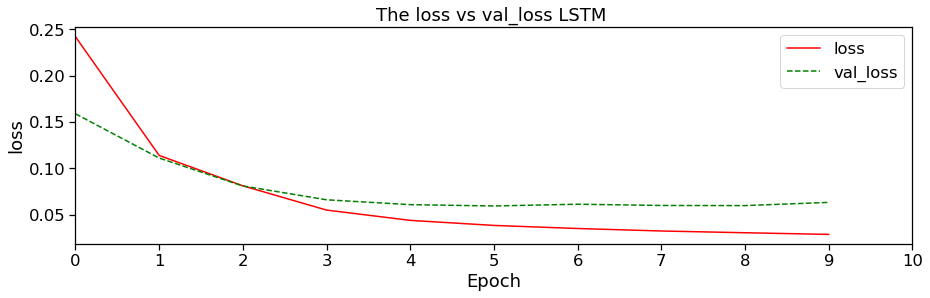

In [23]:
#plot the loss
plt.figure(figsize=(15,4))
plt.plot(history.history['loss'],'r', label='loss')
plt.plot(history.history['val_loss'],'g--', label = 'val_loss')
plt.xticks(range(0,11,1))
plt.xlim(0,10)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('The loss vs val_loss LSTM ')
plt.legend(loc='best');

We used 10 epoch for training the model: on the plot above overfitting appears in the point 3-4 epoch

#### 12. Create a model *model2* that is the same as *model* but with the LSTM layer wrapped by *Bidirectional()*, so the model becomes a BiLSTM model. 

In [24]:
model2 = get_model(flag=True)

model2.input_shape, model2.output_shape

((None, 50), (None, 50, 10))

In [25]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Embedding)           (None, 50, 200)           1000400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 256)           336896    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 50, 10)            2570      
Total params: 1,339,866
Trainable params: 1,339,866
Non-trainable params: 0
_________________________________________________________________


In [26]:
model2.compile(optimizer='adam', loss='categorical_crossentropy')
history2 = model2.fit(X_train, Y_train, 
                      epochs = 10, 
                      batch_size = 128, 
                      validation_data = (X_valid, Y_valid))

/home/gal/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14987 samples, validate on 3466 samples
Epoch 1/10
14987/14987 [==============================] - 51s 3ms/step - loss: 0.2257 - val_loss: 0.1460
Epoch 2/10
14987/14987 [==============================] - 79s 5ms/step - loss: 0.1010 - val_loss: 0.0926
Epoch 3/10
14987/14987 [==============================] - 62s 4ms/step - loss: 0.0568 - val_loss: 0.0637
Epoch 4/10
14987/14987 [==============================] - 58s 4ms/step - loss: 0.0379 - val_loss: 0.0551
Epoch 5/10
14987/14987 [==============================] - 63s 4ms/step - loss: 0.0296 - val_loss: 0.0578
Epoch 6/10
14987/14987 [==============================] - 65s 4ms/step - loss: 0.0248 - val_loss: 0.0482
Epoch 7/10
14987/14987 [==============================] - 57s 4ms/step - loss: 0.0208 - val_loss: 0.0504
Epoch 8/10
14987/14987 [==============================] - 52s 3ms/step - loss: 0.0176 - val_loss: 0.0502
Epoch 9/10
14987/14987 [==============================] - 75s 5ms/step - loss: 0.0154 - val_loss: 0.0491
Epoch 

#### How does this change the final validation loss? 


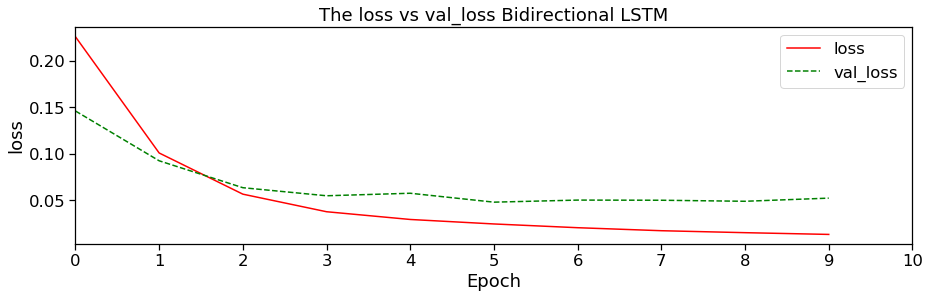

In [27]:
#plot the loss
plt.figure(figsize=(15,4))
plt.plot(history2.history['loss'],'r', label='loss')
plt.plot(history2.history['val_loss'],'g--', label = 'val_loss')
plt.xticks(range(0,11,1))
plt.xlim(0,10)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('The loss vs val_loss Bidirectional LSTM')
plt.legend(loc='best');

#### Does the model improve?

No, we got the same difference in values loss vs val_loss  and the model still overfitting in the point 3-4 epoch

#### 13. Compare the performance of the two models on the test set data X_test and Y_test (Hint: use model.evaluate()).

In [28]:
model1.evaluate(X_test, Y_test, batch_size=128)

3684/3684 [==============================] - 3s 690us/step


0.07203169134683123

In [29]:
model2.evaluate(X_test, Y_test, batch_size=128)

3684/3684 [==============================] - 3s 870us/step


0.06587858334685252

Well, we see, that model2, Bidirectional LSTM, shows better results in loss metric, but not so much

## Bonus 1: Running on custom input



In [30]:
test_sentences = [
  "This is a test.",
  "I live in the United States.",
  "Israel is a country in the Middle East.",
  "UK joins US in Gulf mission after Iran taunts American allies",
  "The project was funded by the Portuguese Foundation for Science and Technology and the Israel Cancer Research Fund."
]

### Bonus question 1:

#### What does your model predict as NER tags for the following test sentences?

#### Hint: Try using the following pipeline on each sentence:

* <b>Tokenize with nltk.word_tokenize()
* Convert to array of indices with word2index() defined above
* Pad to length 50 with pad_sequences() from Keras
* Predict probabilities of NER tags with model2.predict()
* Find maximum likelihood tags using np.argmax(), and ignore padding values</b>

In [31]:
tokens = []
vectors = []
for sent in (test_sentences):
    token = nltk.word_tokenize(sent)
    tokens.append(token)
    vectors.append([token2index(w) for w in token])
pad_seq = pad_sequences(vectors, maxlen=maxlen, padding='pre', value=0)
pred = model2.predict(pad_seq)

Convert to words and tags

In [32]:
test_tags = []

#range of the set's lengh
for n in range(len(test_sentences)):
    
    #this list should be defined incide 1-st for-loop
    sent_tags =[]
    
    # diff between padded and original sentences
    word_indx = maxlen - len(tokens[n]) 

    #go by tokens ignoring zeros
    for w in range(word_indx, len(pred[n])):
        
        #recover real tag index
        pred_tags_idx = np.argmax(pred[n][w],axis=0) - 1
        sent_tags.append(ne_tags[pred_tags_idx])
    test_tags.append(sent_tags)

In [33]:
for i, ne in enumerate(test_tags):
    print(" ".join(tokens[i]),'\n'," , ".join(ne),'\n')   

This is a test . 
 O , O , O , O , O 

I live in the United States . 
 O , O , O , O , B-LOC , I-LOC , O 

Israel is a country in the Middle East . 
 B-LOC , O , O , O , O , O , B-LOC , I-LOC , O 

UK joins US in Gulf mission after Iran taunts American allies 
 B-LOC , O , B-LOC , O , B-LOC , O , O , B-LOC , O , B-MISC , I-LOC 

The project was funded by the Portuguese Foundation for Science and Technology and the Israel Cancer Research Fund . 
 O , O , O , O , O , O , B-MISC , O , O , O , O , O , O , O , B-LOC , O , I-ORG , I-ORG , O 



## Bonus 2: Adding features

### Bonus question 2:

<b>In (B) below, add code to add a new column 'SHAPE' to the dataset. This column should represent the shape of the word token by:
* Replacing all capital letters with 'X'
* Replacing all lowercase letters with 'x'
* Replacing all digits with 'd'

For example, we should have the following:

* 'house' => 'xxxxx'
* 'Apple' => 'Xxxxx'
* 'R2D2' => 'XdXd'
* 'U.K.' => 'X.X.'

Hint: for a Pandas series. you can use series.str.replace() to easily replace text.</b>

In [34]:
def series2shape(series):
  ## (B) -- add bonus question code here
    series = series.str.replace('[A-Z]', 'X')
    series = series.str.replace('[a-z]', 'x')
    series = series.str.replace('\d', 'd')
    return series

train_df['SHAPE'] = series2shape(train_df.TOKEN)
valid_df['SHAPE'] = series2shape(valid_df.TOKEN)
test_df['SHAPE'] = series2shape(test_df.TOKEN)
test_df

,TOKEN,POS,CHUNK,NE,SENTENCE,token_index,ne_index,SHAPE
0,-DOCSTART-,-X-,-X-,O,0,22,1,-XXXXXXXX-
2,SOCCER,NN,B-NP,O,1,126,1,XXXXXX
3,-,:,O,O,1,18,1,-
4,JAPAN,NNP,B-NP,B-LOC,1,1,6,XXXXX
5,GET,VB,B-VP,O,1,1,1,XXX
...,...,...,...,...,...,...,...,...
50344,younger,JJR,I-NP,O,3683,1,1,xxxxxxx
50345,brother,NN,I-NP,O,3683,1,1,xxxxxxx
50346,",",",",O,O,3683,3,1,","
50347,Bobby,NNP,B-NP,B-PER,3683,4343,4,Xxxxx


**Once you complete this, run the following code to see how adding this as a feature improves the performance of the model. For simplicity we only use the top 100 word shapes.**

In [35]:
shape_vocab = [w for w, f in FreqDist(train_df.SHAPE).most_common(n = 100)]
shape_set = set(shape_vocab)

def shape2index(shape):
    if shape in shape_set:
        return shape_vocab.index(shape) + 2
    else: # out-of-vocabulary shape
        return 1

n_words = 50

def df2features2(df):
    df['shape_index'] = df.SHAPE.apply(shape2index)
    token_index_lists = df.groupby('SENTENCE').token_index.apply(list)
    ne_index_lists = df.groupby('SENTENCE').ne_index.apply(list)
    shape_index_lists = df.groupby('SENTENCE').ne_index.apply(list)
    X = np.stack([
      pad_sequences(token_index_lists, maxlen = n_words, value = 0),
      pad_sequences(shape_index_lists, maxlen = n_words, value = 0)
  ])
    Y = to_categorical(pad_sequences(ne_index_lists, maxlen = n_words, value = 0))
    return X, Y

X2_train, Y2_train = df2features2(train_df)
X2_valid, Y2_valid = df2features2(valid_df)
X2_test, Y2_test = df2features2(test_df)

In [36]:
input1 = Input(shape = (50,))
input2 = Input(shape = (50,))
embedded1 = Embedding(
    len(vocab) + 2, 200,
    input_length = 50, mask_zero = True)(input1)
embedded2 = Embedding(
    len(shape_vocab) + 2, 8,
    input_length = 50, mask_zero = True)(input2)
x = concatenate([embedded1, embedded2])
x = Bidirectional(LSTM(128, return_sequences = True))(x)
output = TimeDistributed(Dense(len(ne_tags) + 1, activation = 'softmax'))(x)
model3 = Model(inputs = [input1, input2], outputs = [output])
model3.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [37]:
model3.fit(
    [X2_train[0], X2_train[1]],
    Y2_train, epochs = 5, batch_size = 128,
    validation_data = ([X2_valid[0], X2_valid[1]], Y2_valid))

/home/gal/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14987 samples, validate on 3466 samples
Epoch 1/5
14987/14987 [==============================] - 72s 5ms/step - loss: 0.2153 - val_loss: 0.1220
Epoch 2/5
14987/14987 [==============================] - 67s 4ms/step - loss: 0.0689 - val_loss: 0.0390
Epoch 3/5
14987/14987 [==============================] - 72s 5ms/step - loss: 0.0177 - val_loss: 0.0111
Epoch 4/5
14987/14987 [==============================] - 79s 5ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 5/5
14987/14987 [==============================] - 84s 6ms/step - loss: 0.0020 - val_loss: 0.0027


In [38]:
print("Model3 loss on test data:")
model3.evaluate([X2_test[0], X2_test[1]], Y2_test)

Model3 loss on test data:
3684/3684 [==============================] - 11s 3ms/step


0.003337758025088743

**How does the final loss change?**

WOW!!! ಠ_ಥ

The final loss decreased very much: we got better result == 0.0045 comparing with previous bidirectional lstm == 0.0654

But we got this 'very nice' result only because we were working with only 3 most common characters X, x and d, the rest chars are sintax